In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as lin
from qutip import *

In [28]:
#Parâmetros:

kappa = 1.0                #taxa de dissipação da cavidade
g = 5.0*kappa              #força de interação/constante de acoplamento
epsilon = np.sqrt(0.01)*kappa        #1 fóton na cavidade com 1.0*kappa
Delta1 = 0.0*kappa           
Delta2 = 0.0*kappa         #ressonante (delta2 = 0)
DeltaP = 0.001*kappa
omegac_list = [0.1*kappa,0.5*kappa,1.0*kappa,3.0*kappa]        #frequência de Rabi do campo de controle

       
gamma = 1.0       #taxa de dissipação do átomo (espontâneo)
gamma_13 = 0.5*gamma
gamma_23 = 0.5*gamma

N = 6   #número de estados Focks na cavidade (truncamento)

tlist = np.logspace(0,4,150)/kappa

In [29]:
#Estados ( |k> = (N,k-1) , N úmero total de estados):

state1 = basis(3,0)
state2 = basis(3,1)
state3 = basis(3,2) 

#Operadores (S representa o sigma - sigma_nm = |n><m| - simgma_nm=tensor(qeye(N),staten*statem.dag())):

S11 = tensor(qeye(N),state1*state1.dag())
S22 = tensor(qeye(N),state2*state2.dag()) 
S31 = tensor(qeye(N),state3*state1.dag())
S13 = tensor(qeye(N),state1*state3.dag())
S32 = tensor(qeye(N),state3*state2.dag())
S23 = tensor(qeye(N),state2*state3.dag())
S33 = tensor(qeye(N),state3*state3.dag())

a = tensor(destroy(N),qeye(3))  #operador de aniquilação dos fótons (destrói uma estação do campo)


#Operadores de colapso:

c_ops_cav = np.sqrt(kappa)*a 

c_ops_atom_13 = np.sqrt(gamma_13)*S13

c_ops_atom_23 = np.sqrt(gamma_23)*S23

#Dissipação:

c_ops_list = [c_ops_cav, c_ops_atom_13, c_ops_atom_23]


In [30]:
for i in range(len(omegac_list)):
    
    omegac = omegac_list[i]
    print(omegac)
    
    
    #Hamiltoniano: 

    H = Delta1*S33 + (Delta1-Delta2)*S22 + DeltaP*S11 - DeltaP*a.dag()*a + (g*a*S31 + omegac*S32 + epsilon*a + g*a.dag()*S13 + omegac*S23 + epsilon*a.dag())


    #Evolução temporal: equação mestra

#     psi0 = tensor(basis(N,0), state2)
#     output = mesolve(H,psi0,tlist,c_ops_list,[a.dag()*a,S11,S22,S33])
#     trans_ss_list = output.expect[0]/(4*(epsilon/kappa)**2)
#     sig11_ss_list = output.expect[1]
#     sig22_ss_list = output.expect[2]
#     sig33_ss_list = output.expect[3]

    #Evolução temporal: Propagador
    
    if g*epsilon <= omegac:
        psi0 = tensor(basis(N,0),state1)
    else:
        psi0 = tensor(basis(N,0),state2)
        
    dim = N*3
    rho0_m = ket2dm(psi0).full()
    rho0_vec = rho0_m.reshape((dim**2,1))
    
    trans_ss_list = []
    
    for t in tlist:
        
        L = liouvillian(H,c_ops_list)
        Ut = lin.expm(t*L.full())
        rhot_vec = np.dot(Ut,rho0_vec)
        rhot_m = rhot_vec.reshape((dim,dim))
        trans_ss_list.append(np.trace(np.dot((a.dag()*a).full(),rhot_m))/(4*(epsilon/kappa)**2))
    
    data = np.vstack((tlist,trans_ss_list))
    file_data_store('Oc=%f.dat'%omegac, data.T, numtype="real", numformat="decimal", sep= " ") 

0.1
0.5
1.0
3.0


0
1
2
3


Text(0.5, 1.0, 'Evolução temporal para epsilon')

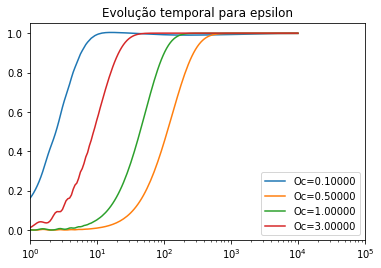

In [35]:
for i in range(len(omegac_list)):
    print(i)
    omegac = omegac_list[i]
    filename = "Oc=%.6f.dat"%omegac
    data = np.loadtxt(filename) #importa o arquivo .dat que você gerou
    tlist = data[:,0] # [:,0] escolhe todas as linhas da primeira coluna
    trans_list = data[:,1] # [:,1] escolhe todas as linhas da segunda coluna
    plt.plot(tlist,trans_list,label="$\Omega_c$=%.5f"%omegac)
    plt.xlim(1, 1E5)
    plt.legend()
    plt.xscale('log')
    plt.xlabel("Tempo ($t \cdot \kappa$)")
    plt.ylabel("Transmissão normalizada")

plt.title("Evolução temporal para epsilon")